In [835]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from ta import add_all_ta_features
import ta
import mplfinance as mpf


pd.set_option('display.max_columns', 1000)

# Set the ticker symbol to be used
ticker = 'GOOG'  # For example, replace 'AAPL' with your desired ticker

# Define the path to your file using the ticker variable
file_path = f'Data/{ticker}_historical_data.csv'
# Read the CSV file into a DataFrame
df_prices = pd.read_csv(file_path)

# Initialize lists to store data from all files
all_dates, all_sentiment_scores, all_relevance_scores, all_avg_relevance_scores = [], [], [], []

# List all JSON files in the directory corresponding to the ticker
json_files = [file for file in os.listdir('Data') if file.startswith(f'{ticker}_news_data') and file.endswith('.json')]

# Iterate over each JSON file
for file in json_files:
    with open(os.path.join('Data', file), 'r', encoding='utf-8') as file:
        data = json.load(file)
        news_feed = data['feed']
    
    # Iterate over the news feed in each file to extract information
    for item in news_feed:
        ticker_info = [ts for ts in item['ticker_sentiment'] if ts['ticker'] == ticker]
        if ticker_info:  # Check if info is available in the ticker sentiment
            all_dates.append(item['time_published'])
            all_sentiment_scores.append(ticker_info[0]['ticker_sentiment_score'])
            all_relevance_scores.append(ticker_info[0]['relevance_score'])
            # Calculate the average relevance score for all tickers in the news item
            avg_relevance = sum(float(ts['relevance_score']) for ts in item['ticker_sentiment']) / len(item['ticker_sentiment'])
            all_avg_relevance_scores.append(avg_relevance)

    # Print length of lists after each file
    print(f"File: {file}, Entries: {len(all_dates)}")

# Create a DataFrame from the collected data
df = pd.DataFrame({
    'Date': all_dates,
    'Sentiment_Score': all_sentiment_scores,
    'Relevance_Score_ticker': all_relevance_scores,
    'Avg_Relevance_Score_topics': all_avg_relevance_scores
})

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date']).dt.normalize()

# Convert relevant columns to float
df['Sentiment_Score'] = df['Sentiment_Score'].astype(float)
df['Relevance_Score_ticker'] = df['Relevance_Score_ticker'].astype(float)
df['Avg_Relevance_Score_topics'] = df['Avg_Relevance_Score_topics'].astype(float)

# Group by 'Date' and calculate mean, min, and max for 'Sentiment_Score'
df_grouped = df.groupby('Date').agg({
    'Sentiment_Score': ['mean', 'min', 'max'],
    'Relevance_Score_ticker': 'mean',
    'Avg_Relevance_Score_topics': 'mean'
}).reset_index()

# Flatten multi-index columns
df_grouped.columns = ['Date', 'Sentiment_Score_mean', 'Sentiment_Score_min', 'Sentiment_Score_max',
                      'Relevance_Score_ticker_mean', 'Avg_Relevance_Score_topics_mean']

# Ensure df_grouped is loaded and has the necessary columns converted to datetime if not already done
df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])
df_grouped.set_index('Date', inplace=True)

# Create a date range from start date to end date
date_range = pd.date_range(start='2023-08-31', end='2024-04-07', freq='D')

# Reindex the DataFrame to include all dates in the range
df_grouped = df_grouped.reindex(date_range)

# Use backward fill to fill initial missing values, then forward fill the rest
df_grouped.bfill(inplace=True)
df_grouped.ffill(inplace=True)

# Resetting index to turn 'Date' back into a column
df_grouped.reset_index(inplace=True)
df_grouped.rename(columns={'index': 'Date'}, inplace=True)

df_prices['Date'] = df_prices['Date'].astype(str)
# Slice the string to extract only the date part
df_prices['Date'] = df_prices['Date'].str[0:10]
# Convert back to datetime
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
# Merge the data on 'Date'
df1 = pd.merge(df_grouped, df_prices[['Date', 'Close', 'Open', 'Volume', 'Low', 'High']], on='Date', how='right')
df = df1

File: <_io.TextIOWrapper name='Data\\GOOG_news_data.json' mode='r' encoding='utf-8'>, Entries: 731
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20230831_20230930.json' mode='r' encoding='utf-8'>, Entries: 1459
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20230901_20231001.json' mode='r' encoding='utf-8'>, Entries: 2188
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20231002_20231102.json' mode='r' encoding='utf-8'>, Entries: 2901
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20231103_20231203.json' mode='r' encoding='utf-8'>, Entries: 3627
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20231204_20240104.json' mode='r' encoding='utf-8'>, Entries: 4361
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20240105_20240205.json' mode='r' encoding='utf-8'>, Entries: 5070
File: <_io.TextIOWrapper name='Data\\GOOG_news_data_20240206_20240307.json' mode='r' encoding='utf-8'>, Entries: 5798


In [836]:
df_grouped.describe()

,Date,Sentiment_Score_mean,Sentiment_Score_min,Sentiment_Score_max,Relevance_Score_ticker_mean,Avg_Relevance_Score_topics_mean
count,221,221.000000,221.000000,221.000000,221.000000,221.000000
mean,2023-12-19 00:00:00,0.079190,-0.179477,0.389426,0.131353,0.156351
min,2023-08-31 00:00:00,0.018722,-0.771966,0.177302,0.050976,0.096749
25%,2023-10-25 00:00:00,0.070928,-0.224269,0.249292,0.107340,0.127465
50%,2023-12-19 00:00:00,0.084544,-0.176058,0.412604,0.132794,0.157616
75%,2024-02-12 00:00:00,0.091087,-0.109898,0.473024,0.163964,0.178847
max,2024-04-07 00:00:00,0.120418,-0.029961,0.735193,0.226404,0.250021
std,NaN,0.016841,0.118408,0.131987,0.043007,0.032677


In [837]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             221 non-null    datetime64[ns]
 1   Sentiment_Score_mean             221 non-null    float64       
 2   Sentiment_Score_min              221 non-null    float64       
 3   Sentiment_Score_max              221 non-null    float64       
 4   Relevance_Score_ticker_mean      221 non-null    float64       
 5   Avg_Relevance_Score_topics_mean  221 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.5 KB


<Figure size 3000x1500 with 0 Axes>

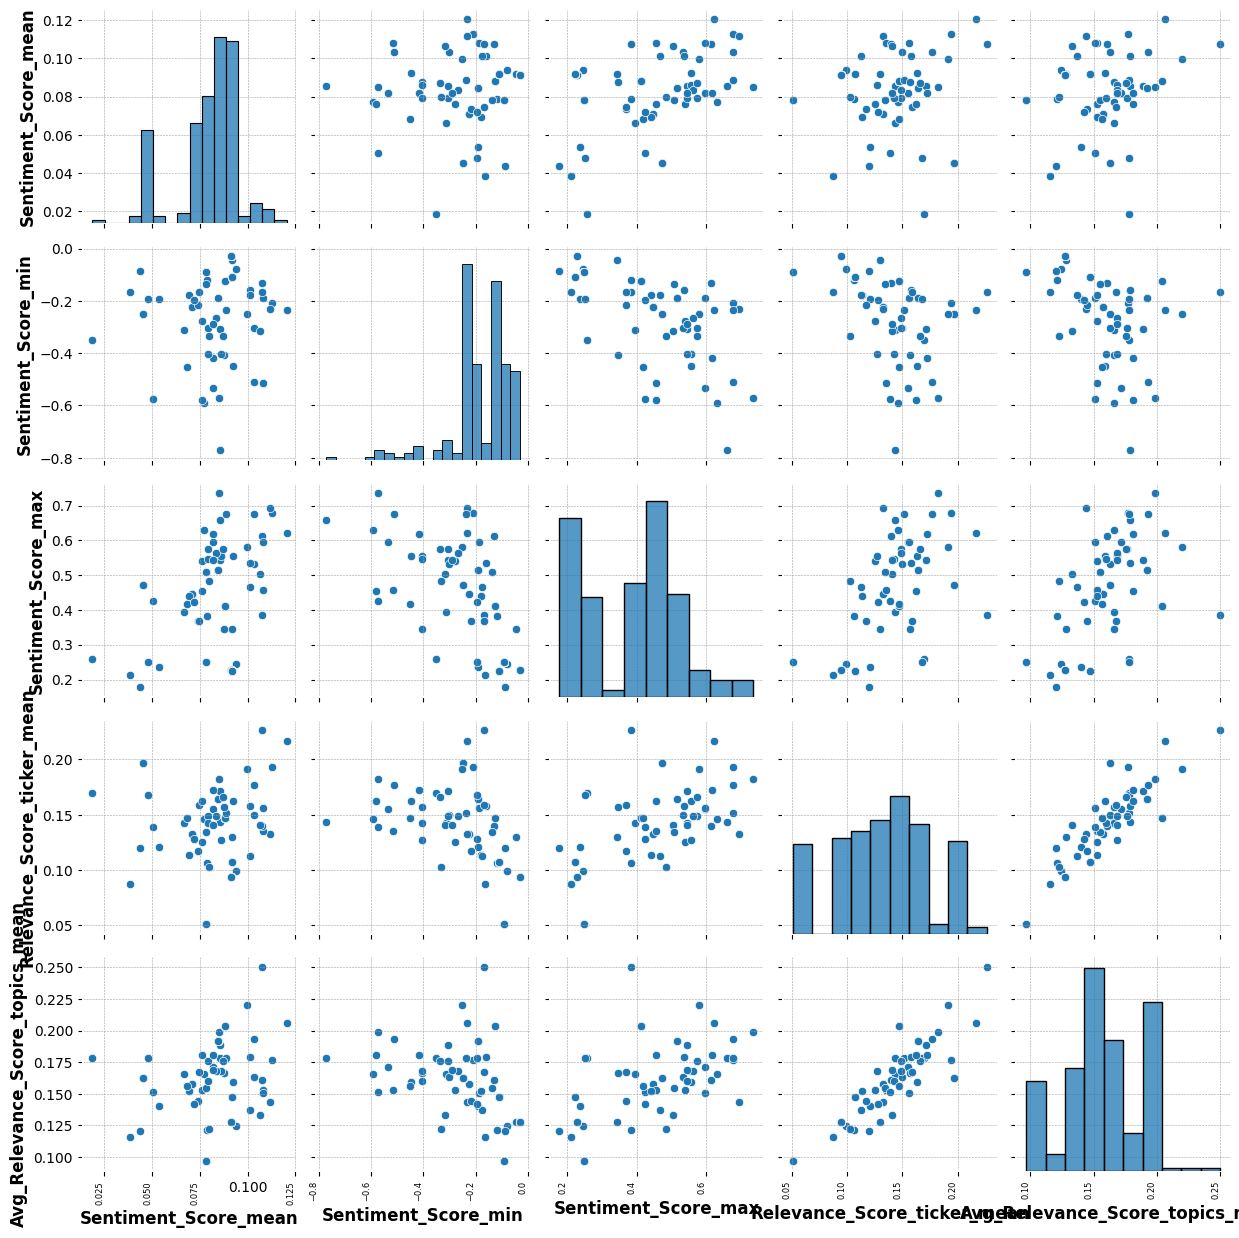

In [838]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sagatavojiet datus
df_grouped1 = df_grouped.drop(columns=['Date'])

# Zīmējiet pairplot ar lielāku platuma izmēru
plt.figure(figsize=(30, 15))  # Palieliniet platuma vērtību
pairplot = sns.pairplot(df_grouped1)

# Pielāgojiet x asis etiķetes katram apakšgrafikam izmantojot setp
for ax_row in pairplot.axes:
    for ax in ax_row:
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=6)

# Parādiet grafiku
plt.tight_layout()
plt.show()

In [839]:
df['Next_Day_Open'] = df['Open'].shift(-1)
df.dropna(subset='Next_Day_Open', inplace=True)

In [840]:
df = df[df.Date <= '2024-04-05']

In [841]:
df_prices

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-05-01,107.720001,108.680000,107.500000,107.709999,20926300,0.0,0.0
1,2023-05-02,107.660004,107.730003,104.500000,105.980003,20343100,0.0,0.0
2,2023-05-03,106.220001,108.129997,105.620003,106.120003,17116300,0.0,0.0
3,2023-05-04,106.160004,106.300003,104.699997,105.209999,19780600,0.0,0.0
4,2023-05-05,105.320000,106.440002,104.738998,106.214996,20705300,0.0,0.0
...,...,...,...,...,...,...,...,...
242,2024-04-17,157.190002,158.681000,156.134995,156.880005,16237800,0.0,0.0
243,2024-04-18,156.925003,158.485001,156.210007,157.460007,14016100,0.0,0.0
244,2024-04-19,157.750000,157.990005,153.910004,155.720001,20063900,0.0,0.0
245,2024-04-22,156.009995,159.184998,155.660004,157.949997,17228000,0.0,0.0


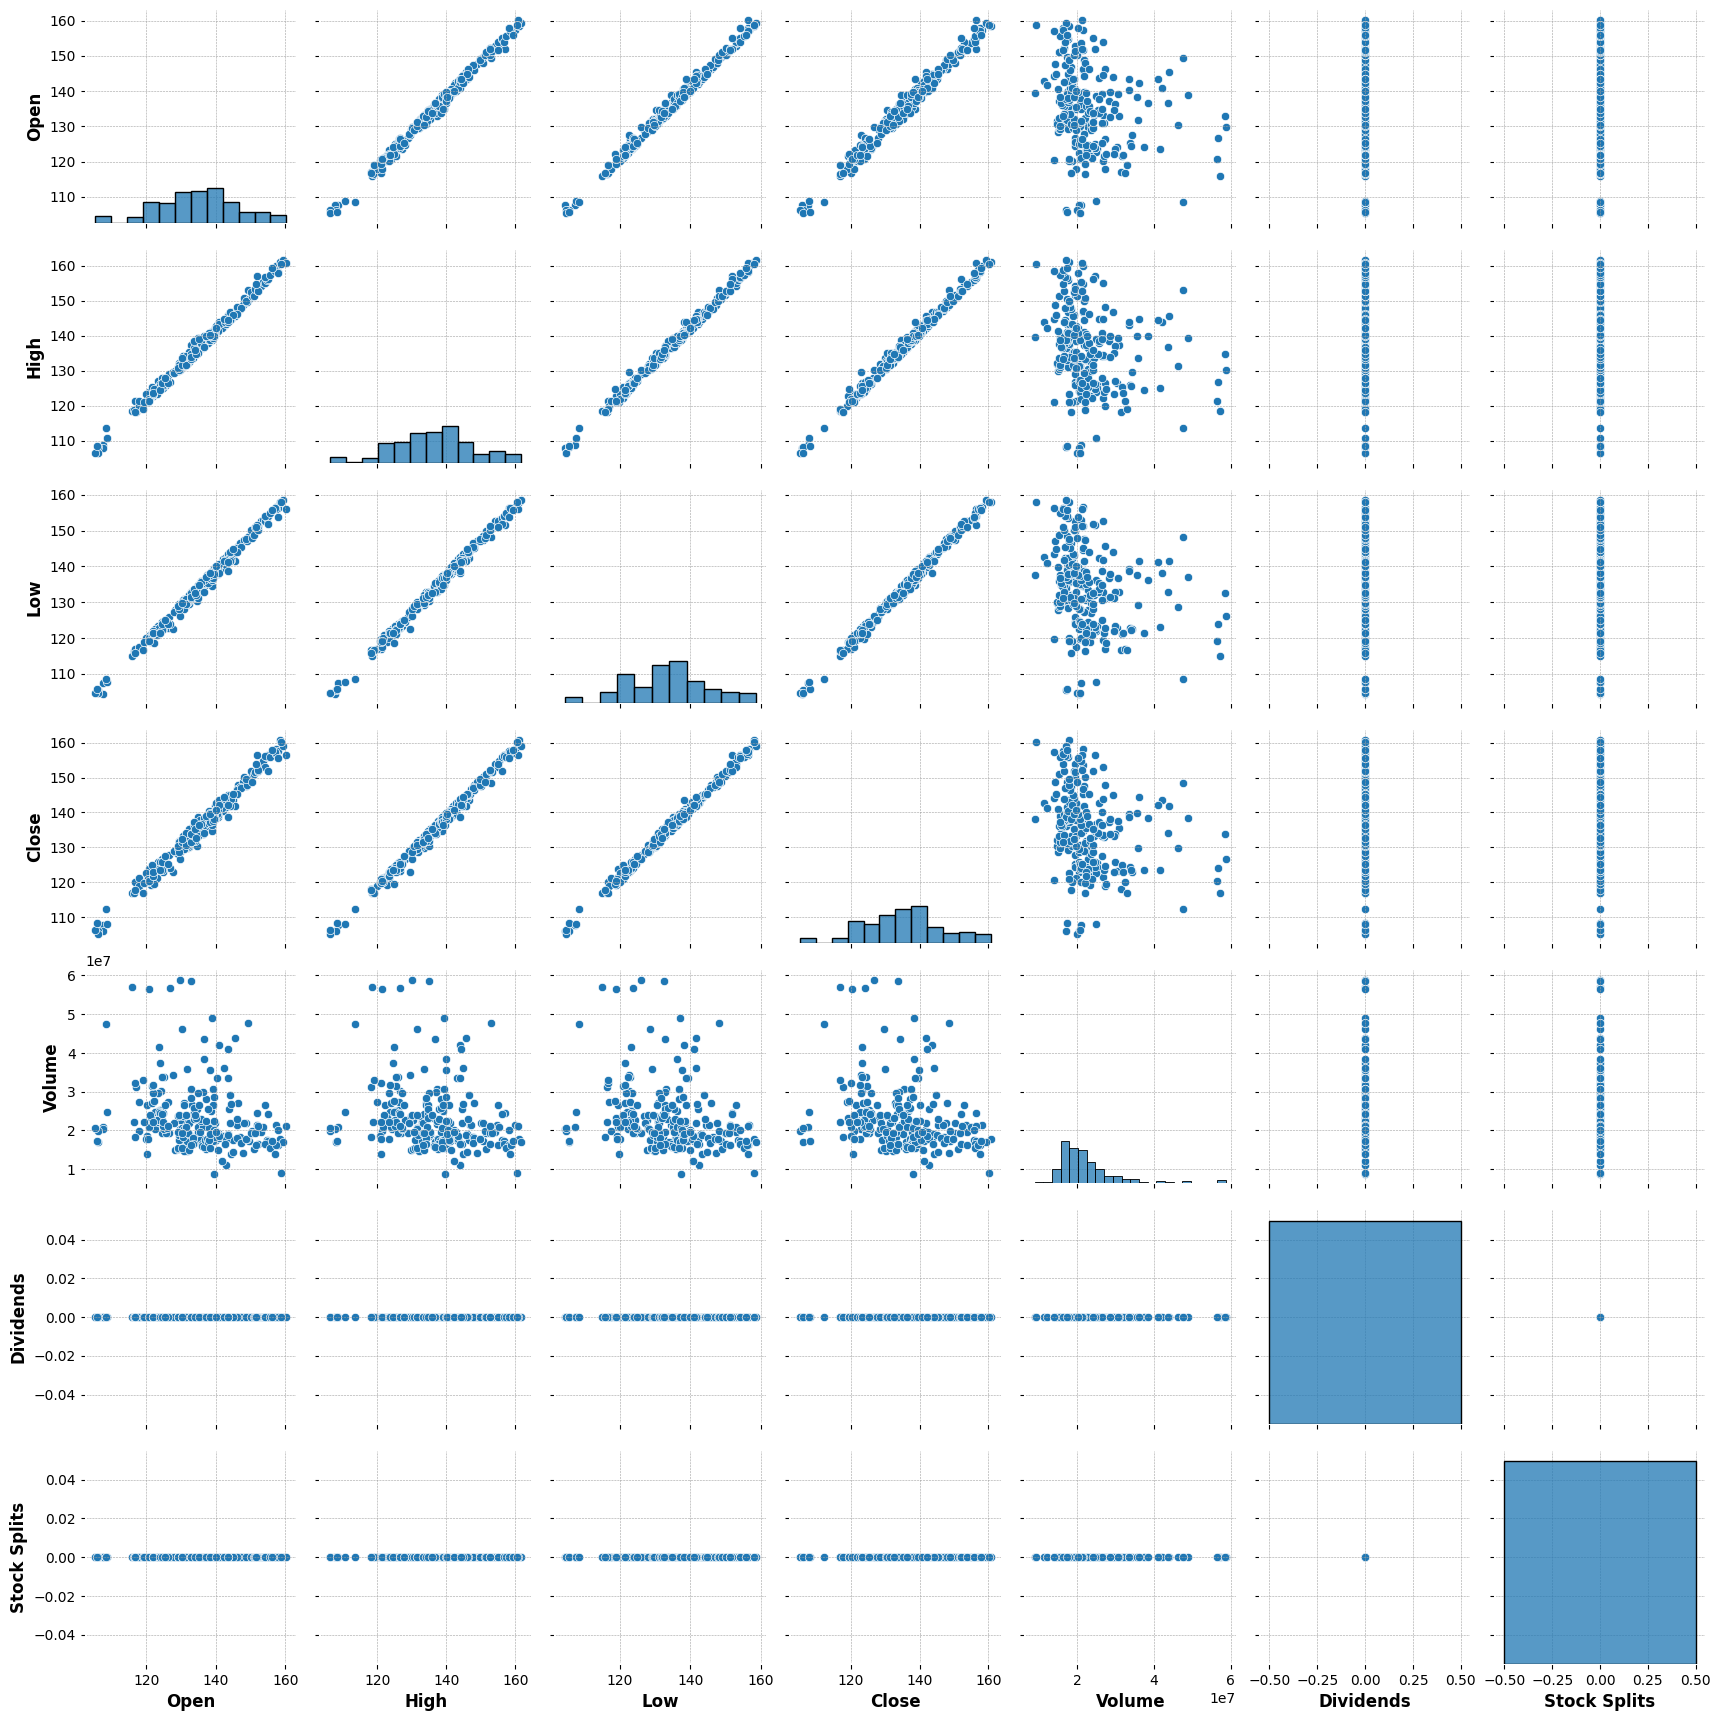

In [842]:
df_prices1 = df_prices.drop(columns=['Date'])

# Create a pairplot to visualize relationships between variables
sns.pairplot(df_prices1)
plt.show()

In [843]:
df_prices

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-05-01,107.720001,108.680000,107.500000,107.709999,20926300,0.0,0.0
1,2023-05-02,107.660004,107.730003,104.500000,105.980003,20343100,0.0,0.0
2,2023-05-03,106.220001,108.129997,105.620003,106.120003,17116300,0.0,0.0
3,2023-05-04,106.160004,106.300003,104.699997,105.209999,19780600,0.0,0.0
4,2023-05-05,105.320000,106.440002,104.738998,106.214996,20705300,0.0,0.0
...,...,...,...,...,...,...,...,...
242,2024-04-17,157.190002,158.681000,156.134995,156.880005,16237800,0.0,0.0
243,2024-04-18,156.925003,158.485001,156.210007,157.460007,14016100,0.0,0.0
244,2024-04-19,157.750000,157.990005,153.910004,155.720001,20063900,0.0,0.0
245,2024-04-22,156.009995,159.184998,155.660004,157.949997,17228000,0.0,0.0


In [844]:
df_prices1.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,247.000000,247.000000,247.000000,247.000000,2.470000e+02,247.0,247.0
mean,134.898701,136.385126,133.729458,135.091801,2.281848e+07,0.0,0.0
std,11.393991,11.374031,11.352388,11.410973,8.420359e+06,0.0,0.0
min,105.320000,106.300003,104.500000,105.209999,8.828600e+06,0.0,0.0
25%,126.649998,128.435001,124.912502,126.649998,1.764670e+07,0.0,0.0
50%,135.035004,136.960007,133.960007,135.490005,2.067530e+07,0.0,0.0
75%,141.990005,143.285004,140.491501,141.779999,2.479870e+07,0.0,0.0
max,160.279999,161.699997,158.600006,160.789993,5.879610e+07,0.0,0.0


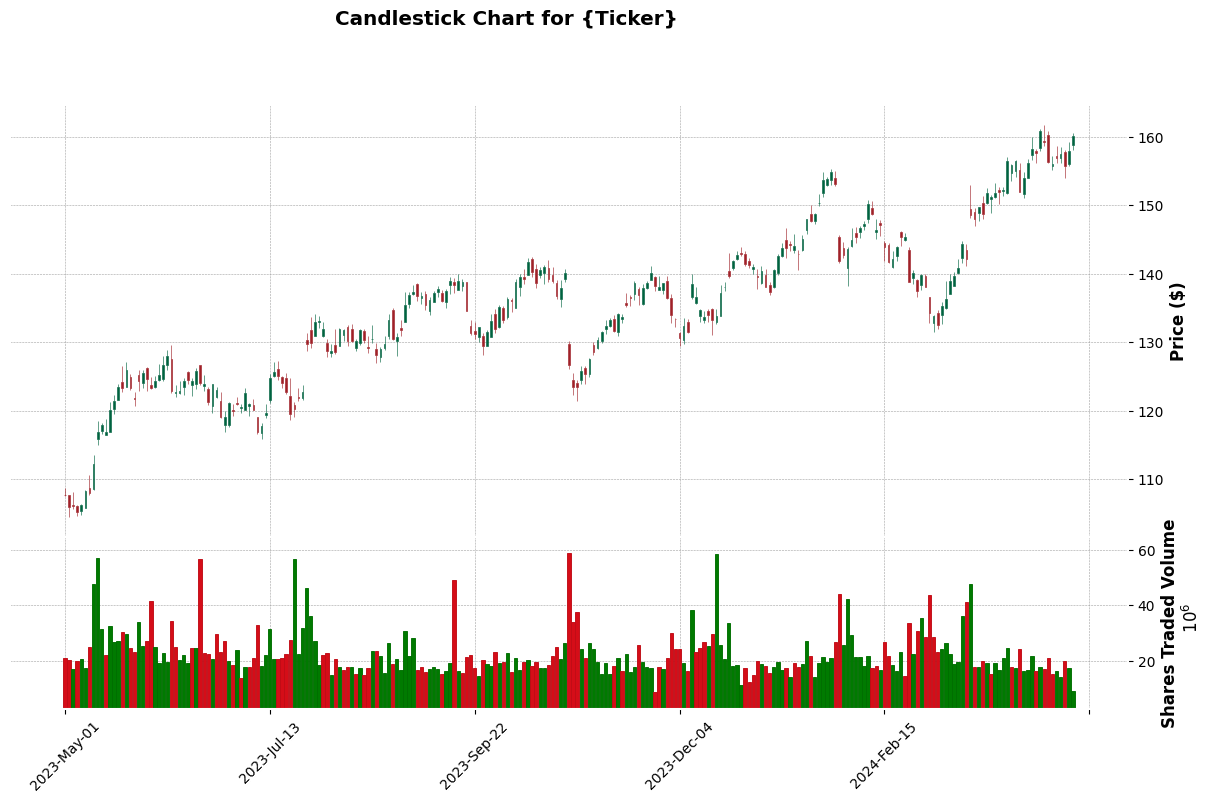

In [845]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.set_index('Date', inplace=True)
mpf.plot(df_prices, type='candle', style='charles',
         title='Candlestick Chart for {Ticker}',
         ylabel='Price ($)',
         volume=True,
         ylabel_lower='Shares Traded Volume',
         figratio=(18, 10),  # Width-to-height ratio (width, height)
         figscale=1.5) 

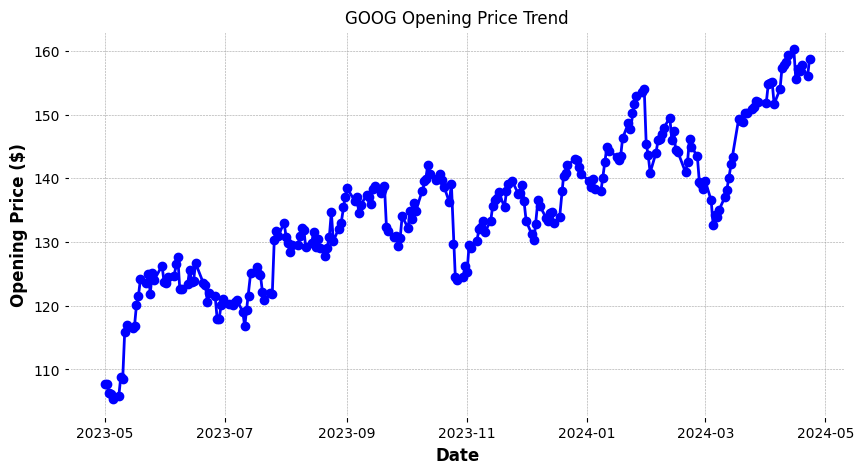

In [846]:
# Plotting the Opening price
plt.figure(figsize=(10, 5))  # Specify the figure size
plt.plot(df_prices.index, df_prices['Open'], marker='o', linestyle='-', color='b')  # Plot line chart
plt.title(f'{ticker} Opening Price Trend')  # Chart title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Opening Price ($)')  # Y-axis label
plt.grid(True)  # Add a grid
plt.show()  # D

In [847]:
### Social meadia - Reddit sentiment
df_reddit_raw = pd.read_csv("Reddit_sentiment_grouped.csv")
df_reddit = df_reddit_raw
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

# Find the global min and max dates across all tickers
global_start_date = df_reddit['Date'].min()
global_end_date = df_reddit['Date'].max()

# Create an empty DataFrame to store results
result_df = pd.DataFrame()

# Process each ticker group separately
for ticker_new, group in df_reddit.groupby('Ticker'):
    # Create date range from the global earliest to the global latest date
    date_range = pd.date_range(start=global_start_date, end=global_end_date, freq='D')
    
    # Reindex the group to include all days in the range, setting Date as the index
    group.set_index('Date', inplace=True)
    group_reindexed = group.reindex(date_range, method='ffill')  # Ensure forward fill is called here

    # Reset the index to turn the date index back into a column
    group_reindexed.reset_index(inplace=True)
    group_reindexed.rename(columns={'index': 'Date'}, inplace=True)

    # Set the Ticker for all rows in the reindexed DataFrame
    group_reindexed['Ticker'] = ticker_new
    
    # Concatenate this reindexed group to the result DataFrame
    result_df = pd.concat([result_df, group_reindexed], ignore_index=True)

In [848]:
result_df_ticker = result_df[result_df.Ticker == ticker]

In [849]:
df = df.merge(result_df_ticker.drop(columns={'Ticker'}), on = 'Date', how = 'left')

C:\Users\new pc\AppData\Local\Temp\ipykernel_20844\842374794.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])


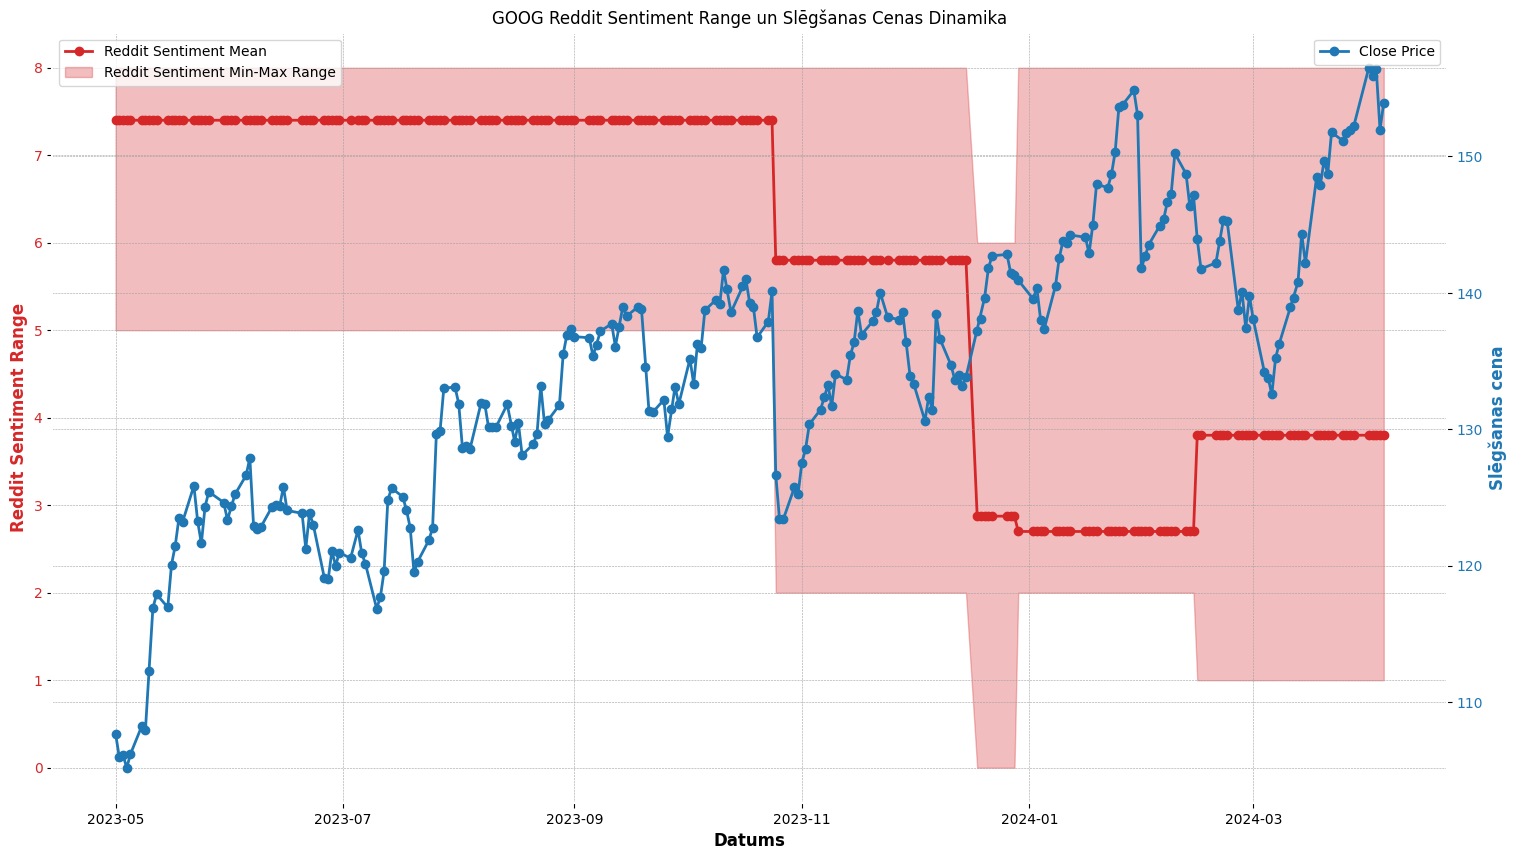

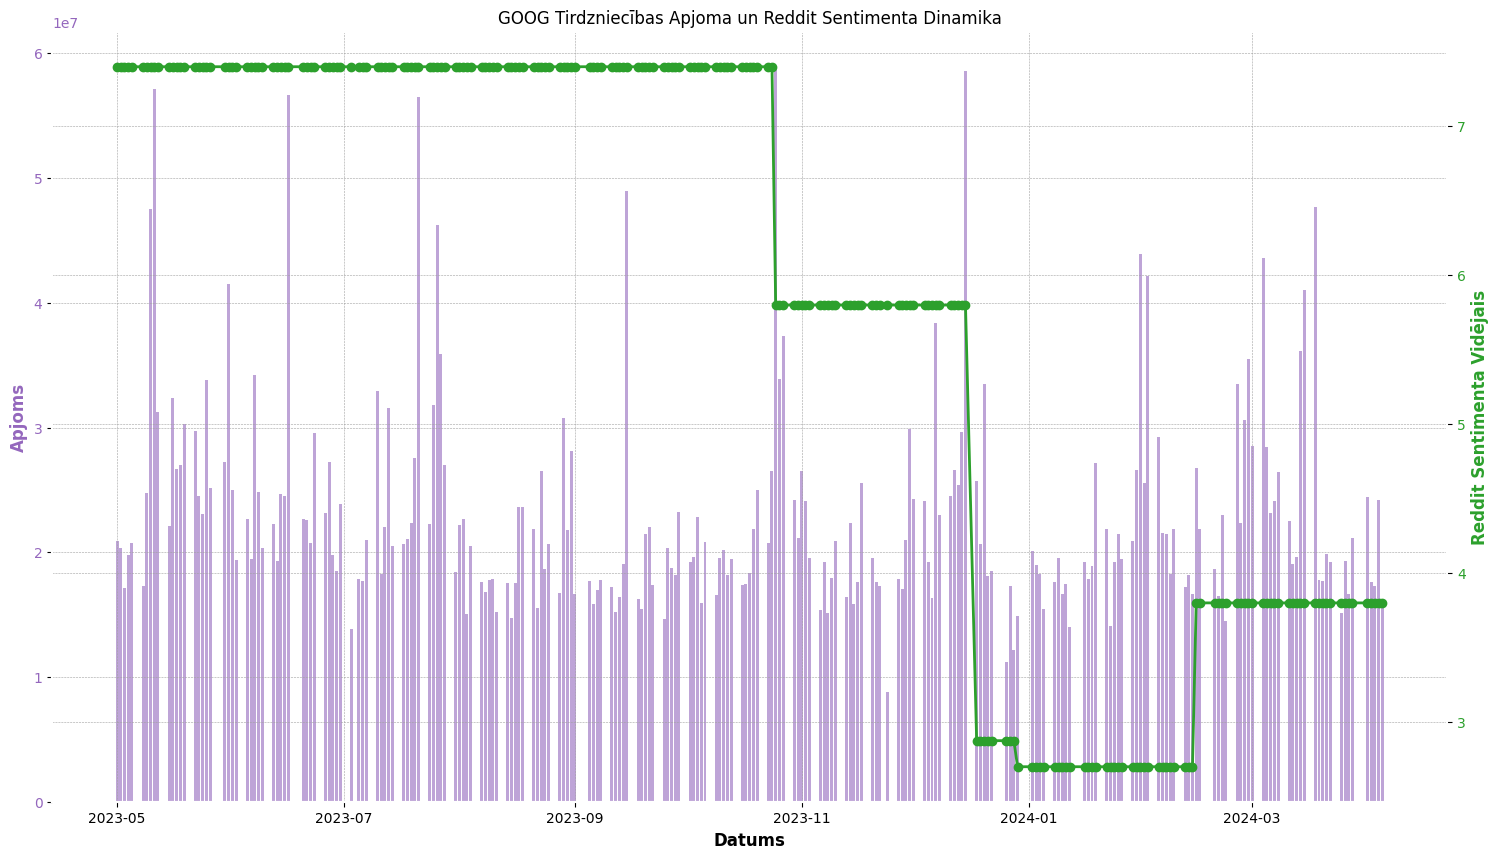

In [851]:
import pandas as pd
import matplotlib.pyplot as plt

# Pieņemam, ka 'df' ir jūsu DataFrame un 'ticker' ir jau definēts kā 'GOOG'
ticker_data = df.dropna(axis=1)  # Filtrējam datus
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Sagatavojam grafiku
fig, ax1 = plt.subplots(figsize=(18, 10))

# Reddit sentimenta vidējais un min-max diapazons
color = 'tab:red'
ax1.set_xlabel('Datums')
ax1.set_ylabel('Reddit Sentiment Range', color=color)
ax1.plot(ticker_data['Date'], ticker_data['Reddit_sentiment_mean'], color=color, marker='o', label='Reddit Sentiment Mean')
ax1.fill_between(ticker_data['Date'], ticker_data['Reddit_sentiment_min'], ticker_data['Reddit_sentiment_max'], color=color, alpha=0.3, label='Reddit Sentiment Min-Max Range')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Finanšu dati, piemēram, slēgšanas cena
ax2 = ax1.twinx()  # Otra ass
color = 'tab:blue'
ax2.set_ylabel('Slēgšanas cena', color=color)
ax2.plot(ticker_data['Date'], ticker_data['Close'], color=color, marker='o', label='Close Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{ticker} Reddit Sentiment Range un Slēgšanas Cenas Dinamika')
plt.show()

# Grafiks par tirdzniecības apjomu un Reddit sentimentu
fig, ax1 = plt.subplots(figsize=(18, 10))

color = 'tab:purple'
ax1.set_xlabel('Datums')
ax1.set_ylabel('Apjoms', color=color)
ax1.bar(ticker_data['Date'], ticker_data['Volume'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Sentiments atkal uz otrās ass
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Reddit Sentimenta Vidējais', color=color)
ax2.plot(ticker_data['Date'], ticker_data['Reddit_sentiment_mean'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'{ticker} Tirdzniecības Apjoma un Reddit Sentimenta Dinamika')
plt.show()


In [854]:
ticker_data_news = df.dropna(axis=1)


C:\Users\new pc\AppData\Local\Temp\ipykernel_20844\1421156236.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data_news['Date'] = pd.to_datetime(ticker_data_news['Date'])


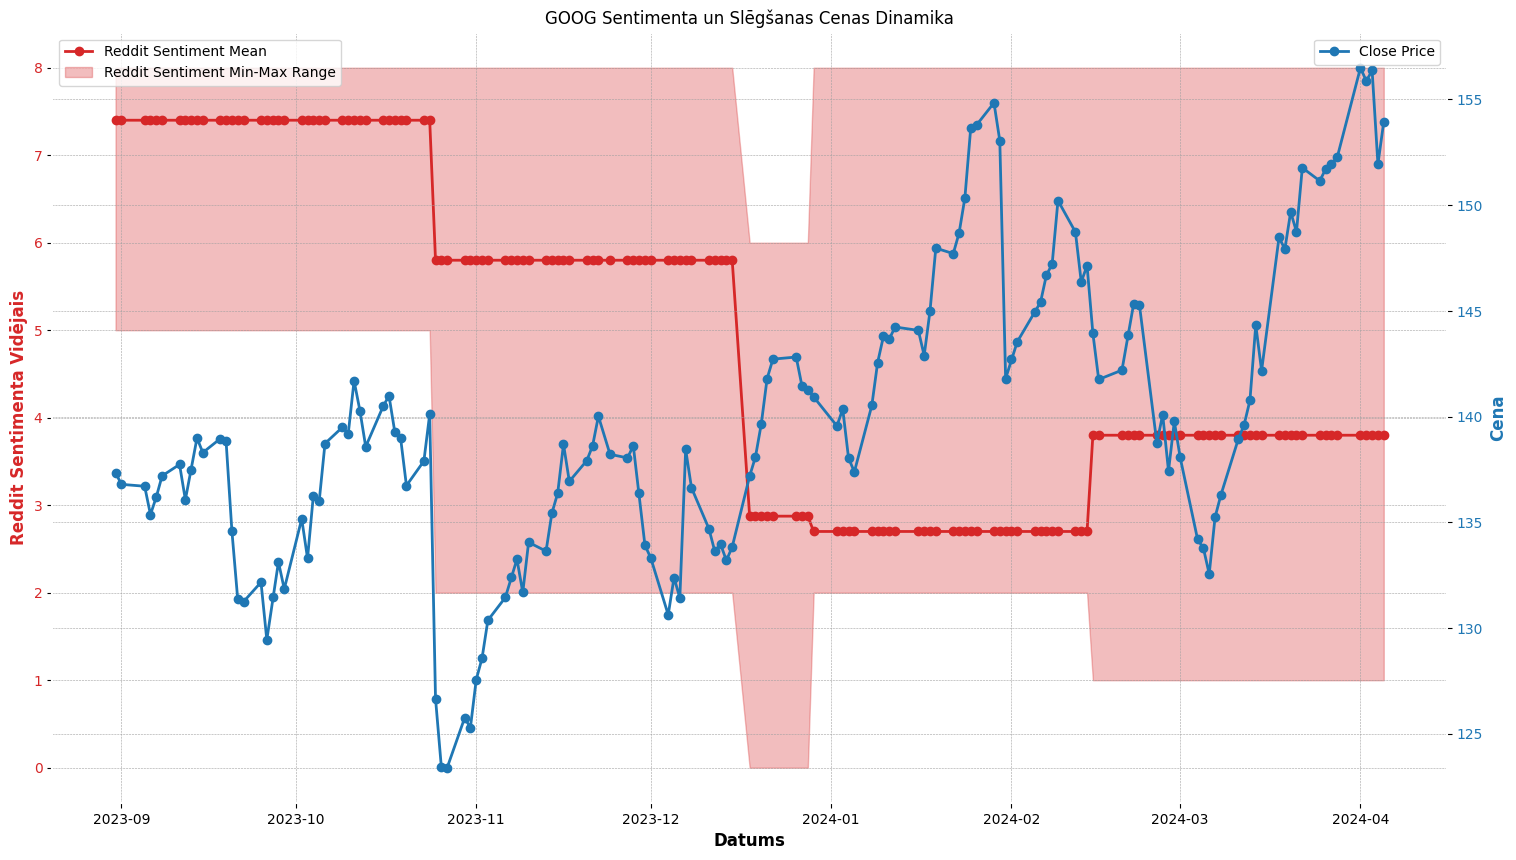

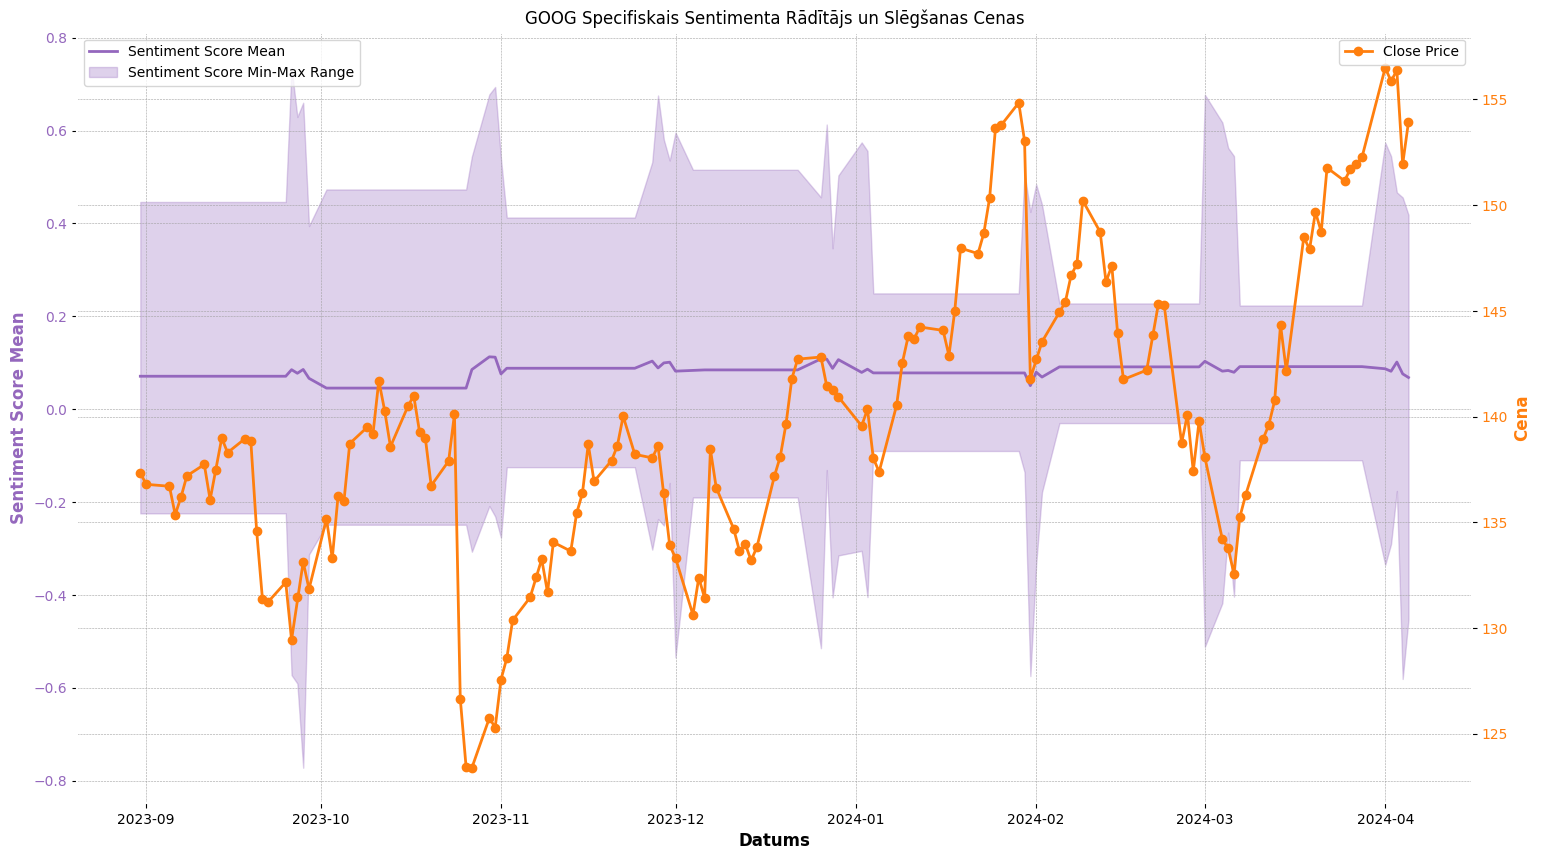

In [855]:
import pandas as pd
import matplotlib.pyplot as plt

ticker_data_news = df.dropna(axis=0)

ticker_data_news['Date'] = pd.to_datetime(ticker_data_news['Date'])
# Sagatavojam grafiku
fig, ax1 = plt.subplots(figsize=(18, 10))

# Reddit sentimenta vidējais
color = 'tab:red'
ax1.set_xlabel('Datums')
ax1.set_ylabel('Reddit Sentimenta Vidējais', color=color)
ax1.plot(ticker_data_news['Date'], ticker_data_news['Reddit_sentiment_mean'], color=color, marker='o', label='Reddit Sentiment Mean')
ax1.fill_between(ticker_data_news['Date'], ticker_data_news['Reddit_sentiment_min'], ticker_data_news['Reddit_sentiment_max'], color=color, alpha=0.3, label='Reddit Sentiment Min-Max Range')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Dubultās ass finanšu dati
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Cena', color=color)
ax2.plot(ticker_data_news['Date'], ticker_data_news['Close'], color=color, marker='o', label='Close Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{ticker} Sentimenta un Slēgšanas Cenas Dinamika')
plt.show()

# Sentiments un cenas dinamikas grafiks ar specifiskajiem sentimenta rādītājiem
fig, ax1 = plt.subplots(figsize=(18, 10))

color = 'tab:purple'
ax1.set_xlabel('Datums')
ax1.set_ylabel('Sentiment Score Mean', color=color)
ax1.plot(ticker_data_news['Date'], ticker_data_news['Sentiment_Score_mean'], color=color, label='Sentiment Score Mean')
ax1.fill_between(ticker_data_news['Date'], ticker_data_news['Sentiment_Score_min'], ticker_data_news['Sentiment_Score_max'], color=color, alpha=0.3, label='Sentiment Score Min-Max Range')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Dubultās ass ar finanšu rādītājiem
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Cena', color=color)
ax2.plot(ticker_data_news['Date'], ticker_data_news['Close'], color=color, marker='o', label='Close Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{ticker} Specifiskais Sentimenta Rādītājs un Slēgšanas Cenas')
plt.show()

In [857]:
df.shape

(235, 15)

### Technical indicators

In [858]:
full_ta = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume"
)

In [860]:
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, AroonIndicator
from ta.trend import AroonIndicator

# Check if 'High' and 'Low' columns exist in the DataFrame
if 'High' in df.columns and 'Low' in df.columns:
    # Initializing the AroonIndicator
    aroon_indicator = AroonIndicator(high=df['High'], low=df['Low'], window=14)
    df['aroon_up'] = aroon_indicator.aroon_up()
    df['aroon_down'] = aroon_indicator.aroon_down()
else:
    print("High or Low columns are missing from the DataFrame.")


# MACD
macd = MACD(df['Close'])
df['macd_line'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_diff'] = macd.macd_diff()

# RSI
df['rsi'] = RSIIndicator(df['Close']).rsi()

# Stochastic Oscillator
stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
df['stoch_k'] = stoch.stoch()
df['stoch_d'] = stoch.stoch_signal()


In [861]:
df = df.dropna(subset=['Next_Day_Open','Sentiment_Score_mean'])

C:\Users\new pc\AppData\Local\Temp\ipykernel_20844\3305966055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


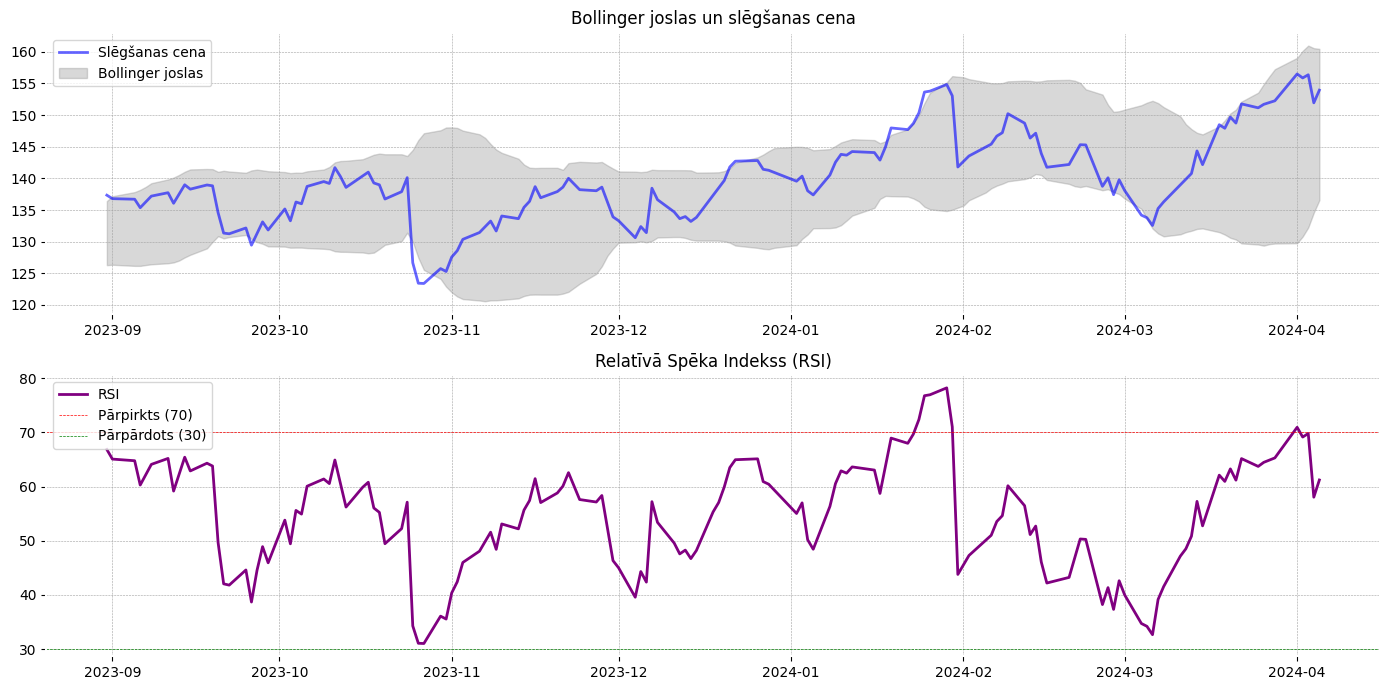

In [862]:
import matplotlib.pyplot as plt
import pandas as pd

# Pieņemsim, ka 'df' ir jūsu DataFrame
df['Date'] = pd.to_datetime(df['Date'])

# Grafiks Bollinger joslas un slēgšanas cena
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Close'], label='Slēgšanas cena', color='blue', alpha=0.6)
plt.fill_between(df['Date'], df['volatility_bbh'], df['volatility_bbl'], color='grey', alpha=0.3, label='Bollinger joslas')
plt.title('Bollinger joslas un slēgšanas cena')
plt.legend()

# Grafiks RSI
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['momentum_rsi'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', linewidth=0.5, label='Pārpirkts (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=0.5, label='Pārpārdots (30)')
plt.title('Relatīvā Spēka Indekss (RSI)')
plt.legend()

plt.tight_layout()
plt.show()


In [863]:
df.shape

(150, 109)

In [864]:
null_percentage = df.isnull().mean() * 100

# Sort the percentages in descending order
sorted_null_percentage = null_percentage.sort_values(ascending=False)

# Display the sorted percentages
print(sorted_null_percentage)

trend_psar_down    62.666667
trend_psar_up      37.333333
Date                0.000000
trend_adx_neg       0.000000
momentum_rsi        0.000000
                     ...    
volatility_kch      0.000000
volatility_kcc      0.000000
volatility_bbli     0.000000
volatility_bbhi     0.000000
stoch_d             0.000000
Length: 109, dtype: float64


In [865]:
# Drop those 2 columns that still have those empty values
df = df.dropna(axis=1, how='any')

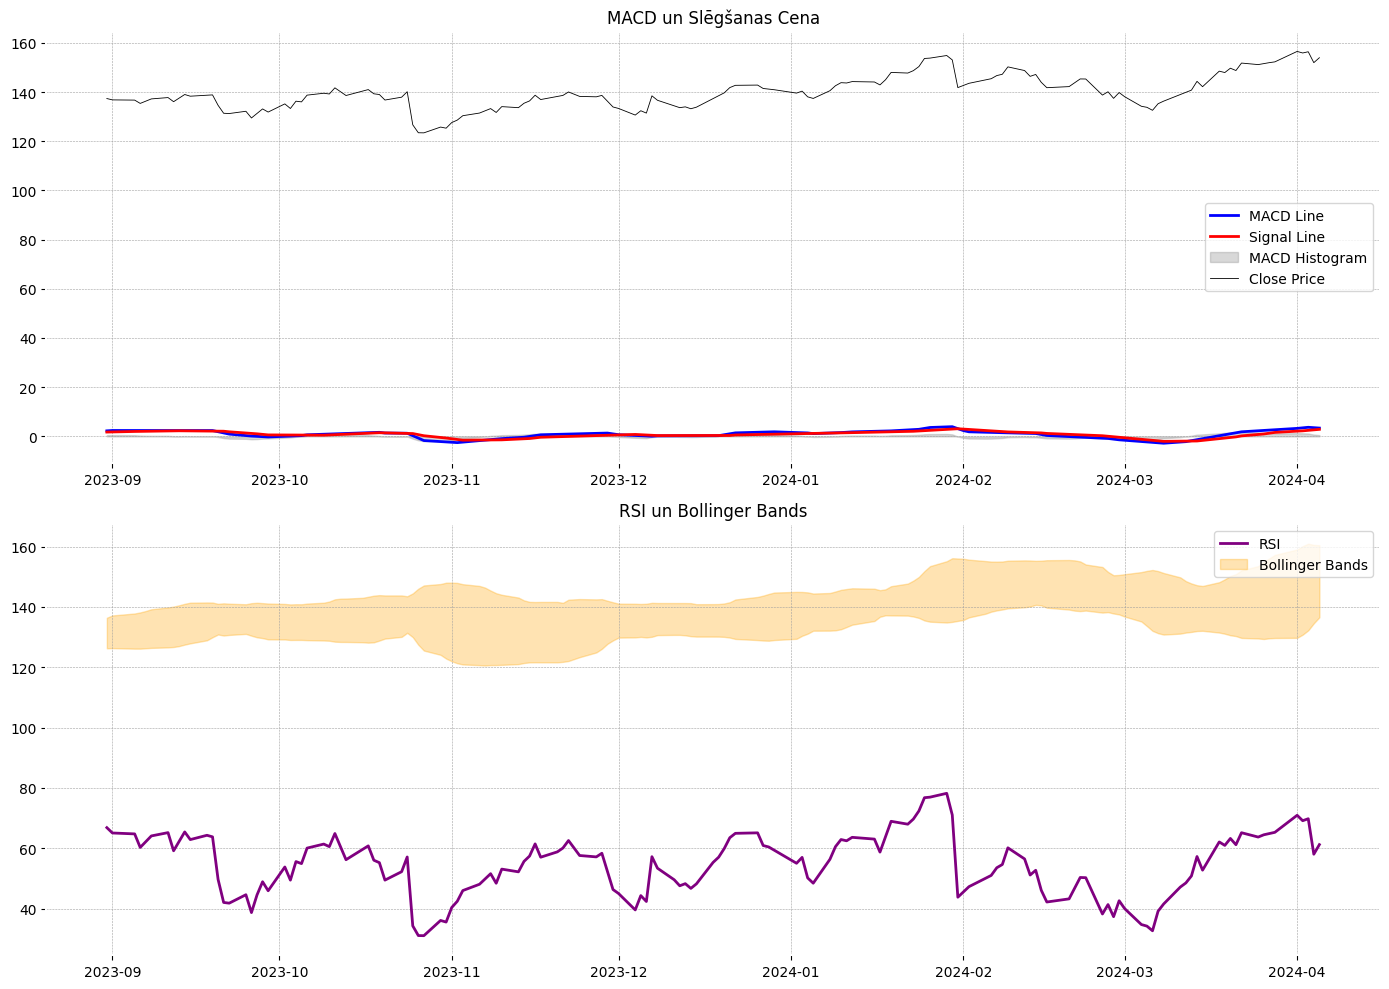

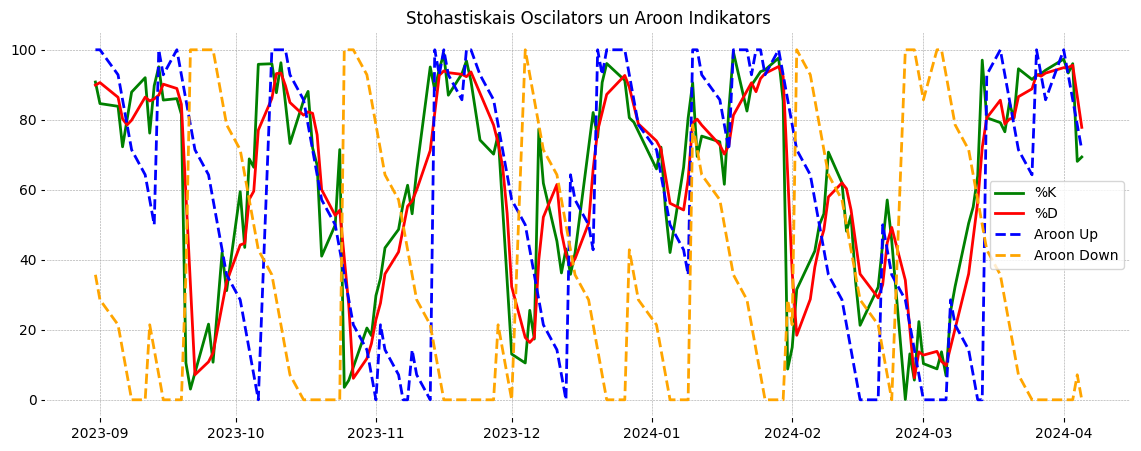

In [866]:
# Grafika sagatavošana
plt.figure(figsize=(14, 10))

# MACD un cena
plt.subplot(2, 1, 1)  # Divi grafiki, pirmais grafiks
plt.plot(df['Date'], df['macd_line'], label='MACD Line', color='b')
plt.plot(df['Date'], df['macd_signal'], label='Signal Line', color='r')
plt.fill_between(df['Date'], df['macd_diff'], label='MACD Histogram', color='grey', alpha=0.3)
plt.plot(df['Date'], df['Close'], label='Close Price', color='black', linewidth=0.6)
plt.title('MACD un Slēgšanas Cena')
plt.legend()

# RSI un Bollinger Bands
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['rsi'], label='RSI', color='purple')
plt.fill_between(df['Date'], df['volatility_bbh'], df['volatility_bbl'], color='orange', alpha=0.3, label='Bollinger Bands')
plt.title('RSI un Bollinger Bands')
plt.legend()

# Parādīt grafiku
plt.tight_layout()
plt.show()

# Stohastiskais Oscilators un Aroon
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['stoch_k'], label='%K', color='green')
plt.plot(df['Date'], df['stoch_d'], label='%D', color='red')
plt.plot(df['Date'], df['aroon_up'], label='Aroon Up', color='blue', linestyle='dashed')
plt.plot(df['Date'], df['aroon_down'], label='Aroon Down', color='orange', linestyle='dashed')
plt.title('Stohastiskais Oscilators un Aroon Indikators')
plt.legend()
plt.show()